# 异常检测
# note:
* [covariance matrix](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html)
* [seaborn  bivariate kernel density estimate](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection  import train_test_split

You want to divide data into 3 set. 
1. Training set(non-labeled)
2. Cross Validation set(labeled)
3. Test set.  (labeled)


In [4]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [5]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

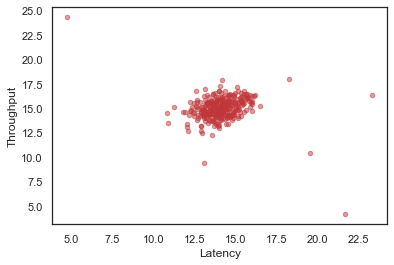

In [6]:
sns.regplot(x='Latency', y='Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.5})
plt.show()

# estimate multivariate Gaussian parameters $\mu$ and $\sigma^2$

In [7]:
mu = X.mean(axis=0) 
print(mu, '\n')

cov = np.cov(X.T) # sigma
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


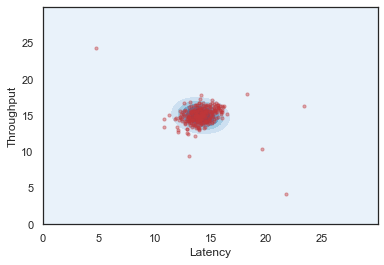

In [9]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov) # 求p()

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot(x='Latency', y='Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

# select threshold $\epsilon$
1. use training set $X$ to model the multivariate Gaussian
2. use cross validation set $(Xval, yval)$ to find the best $\epsilon$ by finding the best `F-score`

<img style="float: left;" src="../img/f1_score.png">

In [11]:
from sklearn.metrics import f1_score, classification_report
def select_threshold(X, Xval, yval):
    mu = X.mean(axis=0)
    sigma = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, sigma)
    
    pval = multi_normal.pdf(Xval) # cv set to predict
    
    # 设置候选的 epsilon 范围是从 min P -> max P 的等差数列，有 10000 个 data
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)
    
    # calculate f-score
    f_score = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        f_score.append(f1_score(yval, y_pred))
    
    # best f1-score
    argmax_f_score = np.argmax(f_score)
    
    #return best epsilon and f1-score
    return epsilon[argmax_f_score], f_score[argmax_f_score]

In [12]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.613554474035228e-05
Best F-score on validation data: 1.0


# visualize prediction of `Xval` using learned $\epsilon$
1. use CV data to find the best $\epsilon$
2. use all data (training + validation) to create model
3. do the prediction on test data

In [13]:
def predict(X, Xval, epsilon, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    # y_pred is anomaly samples
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred


In [14]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       150
           1       1.00      0.50      0.67         4

    accuracy                           0.99       154
   macro avg       0.99      0.75      0.83       154
weighted avg       0.99      0.99      0.98       154



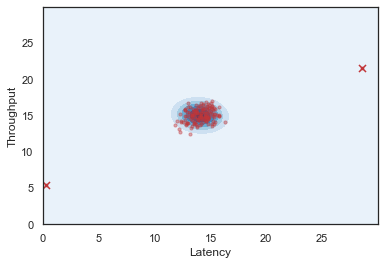

In [15]:

data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot(x='Latency', y='Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

'''
flag predicted anomaly samples with test set,
because training set to fit model,
and cv set to find epsilon,
so use test set to predict y
'''
anomaly_data = data[data['y_pred']==1]
ax.scatter(x=anomaly_data['Latency'], y=anomaly_data['Throughput'], marker='x', s=50)
plt.show()

In [16]:
print('find {} anamolies'.format(y_pred.sum()))

find 2 anamolies
